# Laboratory task 1

**Introduction**

> Social media occupies a very important place in modern human life and has a strong influence on daily life. A huge flow of information related to a person's thoughts, experiences, emotions, and the world that surrounds him/her is transmitted through them. Exploring social media streams allows you to observe processes taking place in the city, to predict emerging anomalies and events, allowing you to react to them in a timely manner. In this assignment you will learn how to use historical social network data about the frequency of publications in different urban areas to predict future distribution.


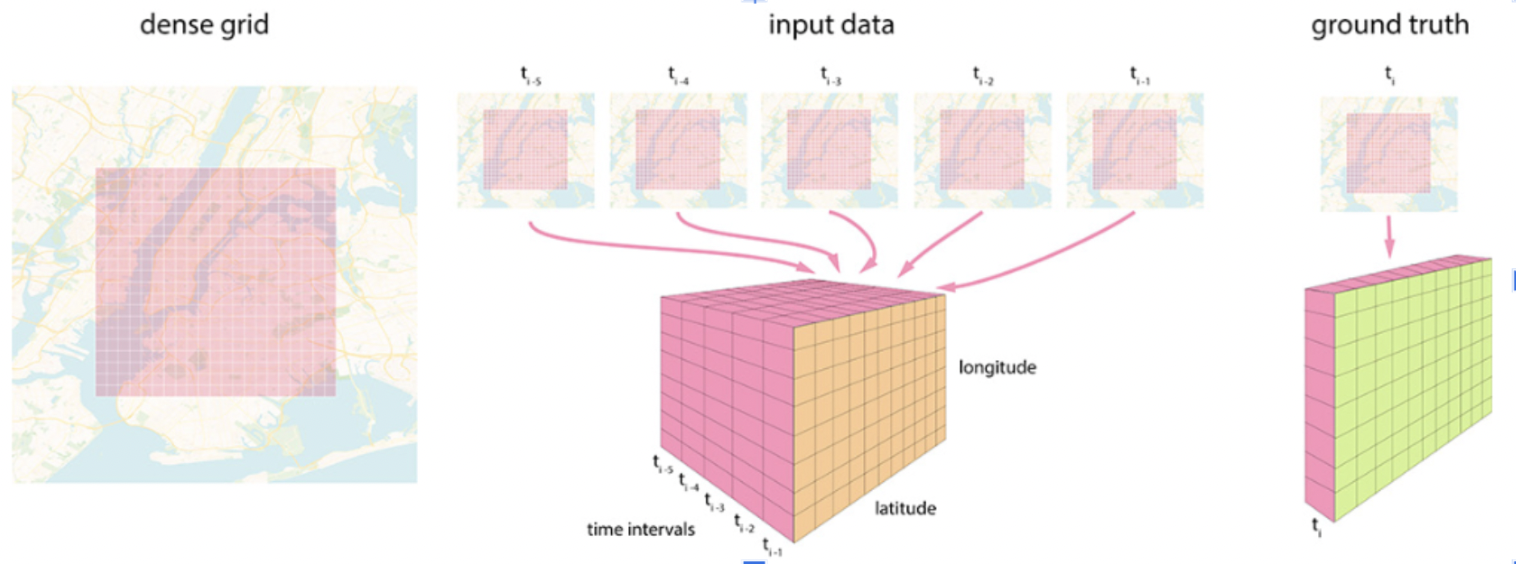





> You are presented with a dataset of one popular social network that includes more than 8.5 million records with meta-information of publications over 13 months (January 2019 to February 2020).



*   lon, lat – geoposition coordinates rounded up to a 250x250 meter polygon (geographical longitude and latitude, respectively)
*   timestamp – timestamp of the publication accurate to one hour
*   likescount – number of "likes" in the publication
*   commentscount – number of comments of the publication
*   symbols_cnt – number of all symbols in the publication
*   words_cnt – number of words (meaningful, not counting special characters and other meta-information)
*   hashtags_cnt – number of hashtags
*   mentions_cnt – the number of mentions of other users
*   links_cnt – number of links
*   emoji_cnt – number of emoji.
*   point – service field for matching coordinates from training, validation and test datasets (if two elements have the same point, they have the same coordinates, comparison of lat and lon may give an error)

Using this data, you will need to predict the number of publications in each 250x250 meter polygon for each hour 4 weeks (28 days) ahead of the last publication in the training set.

The square with coordinates of two opposite corners (60.039332, 30.515771) and (59.831191, 30.142969) can be considered as boundaries, it is guaranteed that in the test dataset the coordinates do not exceed these boundaries.

In [1]:
import os

In [2]:
os.chdir("../")
%pwd

'/Users/macbookpro/Documents/predict_publications/publications_prediction'

# Load Data

> Let's load dataset from Google Drive, Ensure you have the dataset uploaded on your Drive.




In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib


In [7]:
train_df = pd.read_csv('/Users/macbookpro/Documents/predict_publications/publications_prediction/data/train_data.csv')
validation_df = pd.read_csv('/Users/macbookpro/Documents/predict_publications/publications_prediction/data/validation_data.csv')

In [8]:
train_df.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8526526 entries, 0 to 8526525
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   lon            float64
 2   lat            float64
 3   likescount     int64  
 4   commentscount  int64  
 5   symbols_cnt    int64  
 6   words_cnt      int64  
 7   hashtags_cnt   int64  
 8   mentions_cnt   int64  
 9   links_cnt      int64  
 10  emoji_cnt      int64  
 11  point          object 
dtypes: float64(2), int64(9), object(1)
memory usage: 780.6+ MB


In [10]:
validation_df.head()

,hour,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [11]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hour    686 non-null    int64  
 1   lat     686 non-null    float64
 2   lon     686 non-null    float64
 3   point   686 non-null    object 
 4   sum     686 non-null    int64  
 5   error   686 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 32.3+ KB


# Exploratory Data Analysis

> Let's start with the exploratory data analysis (EDA) to gain insights from. Let's begin with the **temporal distribution** of the number of publications over time.

 the data.

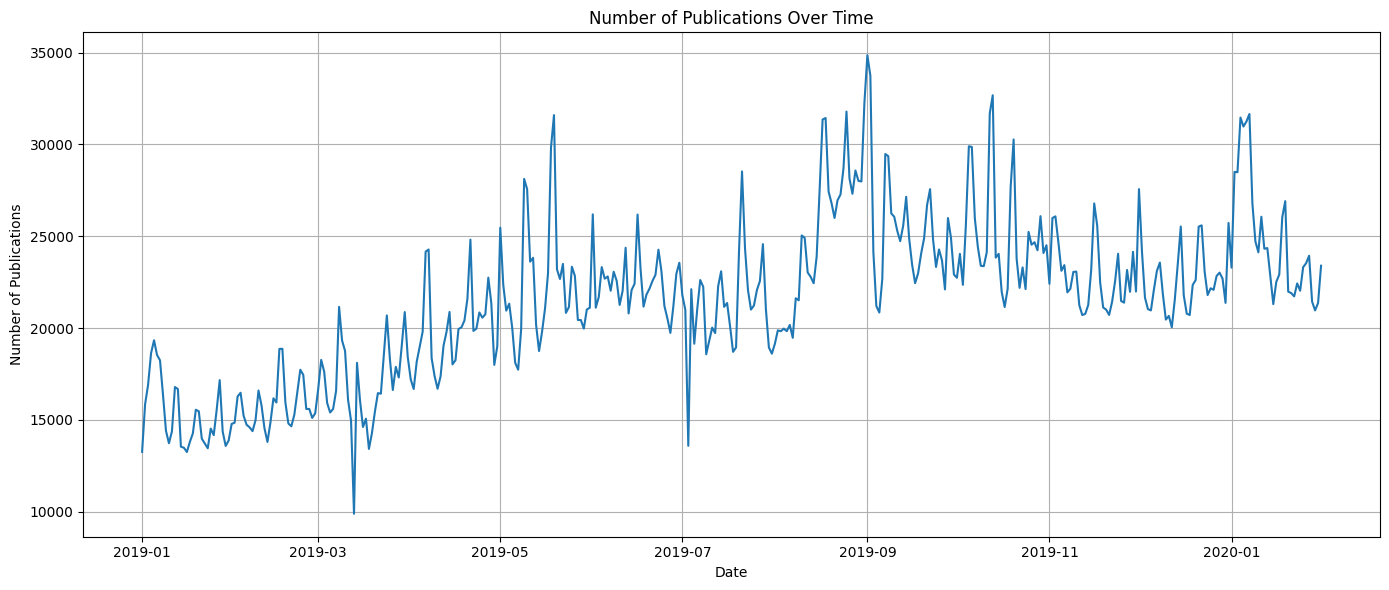

In [12]:
# Convert the timestamp to datetime format for better visualization
train_df['date'] = pd.to_datetime(train_df['timestamp'], unit='s')

# Group by date and count the number of publications
date_counts = train_df.groupby(train_df['date'].dt.date).size()

# Plot
plt.figure(figsize=(14, 6))
date_counts.plot()
plt.title('Number of Publications Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation**

* **Trend**: There seems to be a general upward trend in the number of publications, indicating increasing usage of the social network over time.

* **Seasonality**: There are noticeable periodic patterns in the data. This could be related to weekly cycles (e.g., more posts during weekends) or monthly cycles.

* **Volatility**: Some spikes and troughs can be observed, suggesting specific days or periods with unusually high or low activity.

> let's visualize the spatial distribution of publications to identify potential hotspots or areas with higher or lower activity. We'll create a heatmap using the latitude and longitude values.

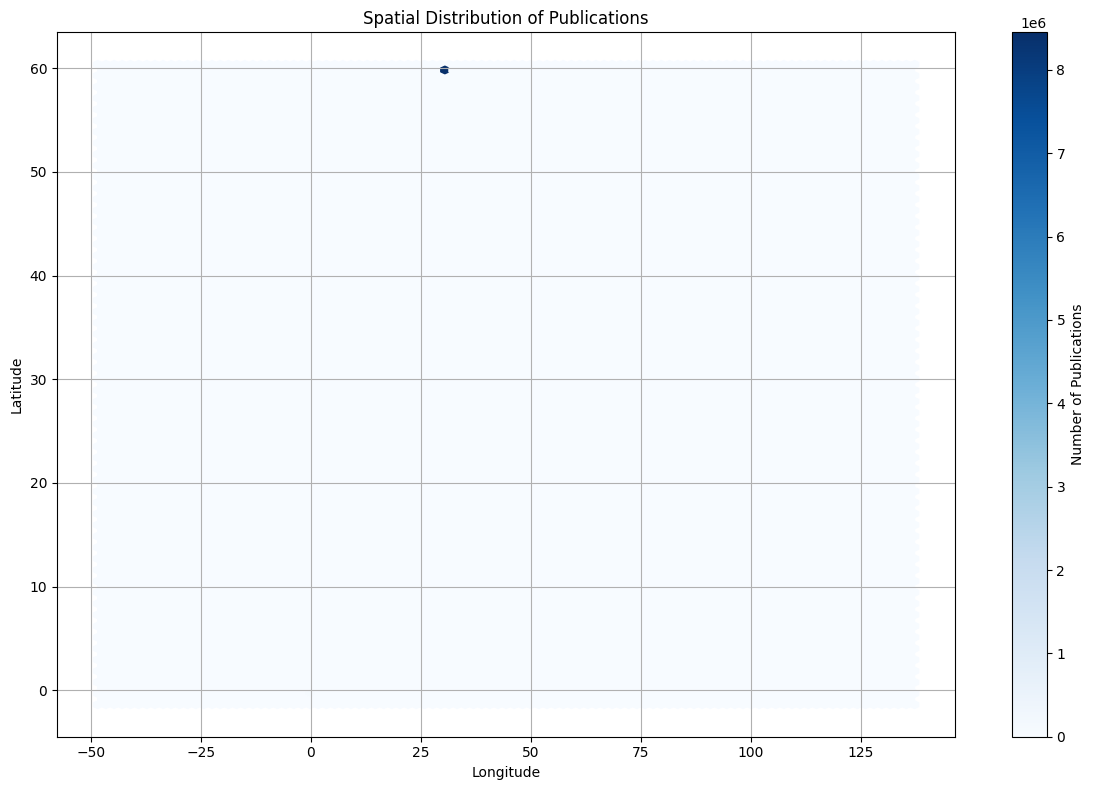

In [13]:
plt.figure(figsize=(12, 8))
plt.hexbin(train_df["lon"], train_df["lat"], gridsize=100, cmap="Blues")
plt.colorbar(label='Number of Publications')
plt.title("Spatial Distribution of Publications")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation**

* **Darker Hexagons**: Indicate areas with a higher density of publications.
* **Lighter Hexagons**: Represent areas with fewer publications.

From the plot, we can observe that there are specific regions or "hotspots" within the city where the density of publications is notably high. This could correspond to popular or densely populated areas.

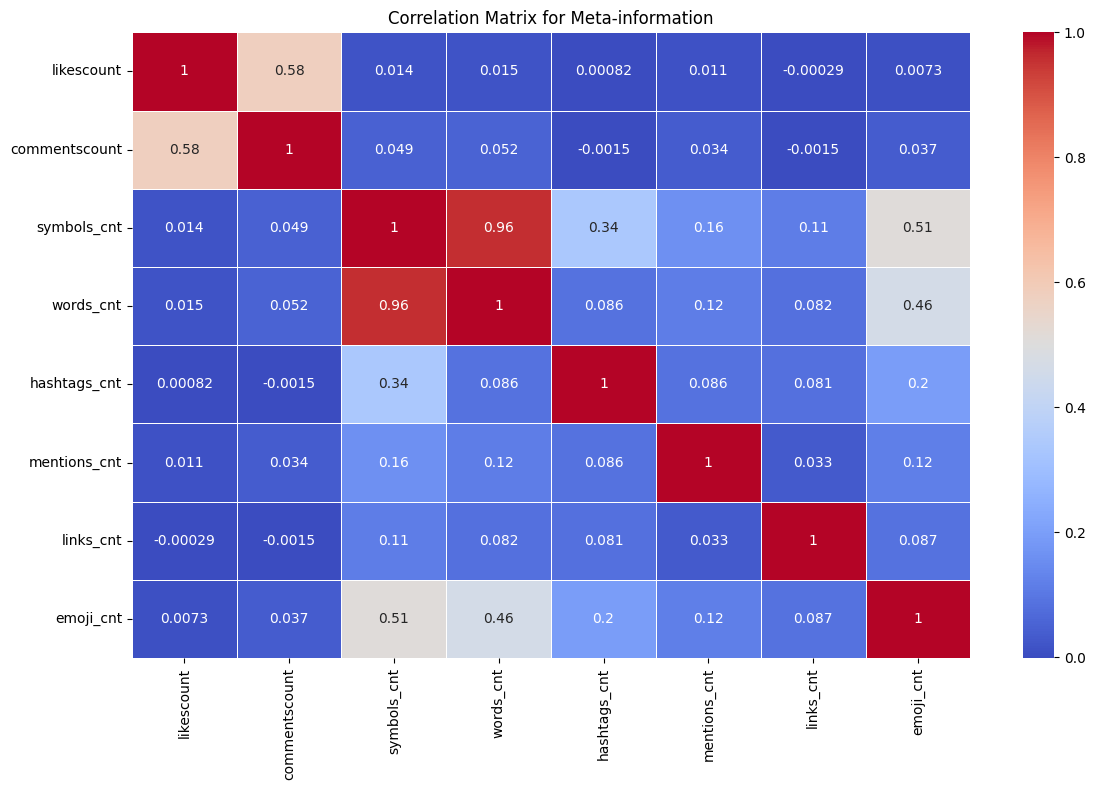

In [14]:
'''
Let's understand the correlation between meta-information (likes, comments, etc.)
and the number of publications. For this, we'll create a correlation matrix
to see how these features are related to one another.
'''

# Selecting columns for correlation analysis
correlation_cols = [
    'likescount', 'commentscount', 'symbols_cnt', 'words_cnt', 'hashtags_cnt',
    'mentions_cnt', 'links_cnt', 'emoji_cnt'
]

correlation_matrix = train_df[correlation_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix for Meta-information")
plt.tight_layout()
plt.show()

**Obervation**



*   **Positive Correlation**: Values closer to 1 indicate a strong positive correlation between two attributes. For instance, symbols_cnt and words_cnt have a strong positive correlation, which is expected because more symbols typically mean more words.
*   **Negative Correlation**: Values closer to -1 indicate a strong negative correlation, though we don't observe any pronounced negative correlations in this dataset.
*   **No Correlation**: Values around 0 suggest a lack of correlation between the two attributes.

**From the heatmap:**

1. *symbols_cnt* and *words_cnt* are highly correlated.
2. *likescount* has a moderate correlation with *commentscount*
3. *hastags_cnt* has a slightly lesser correlation with *symbols_cnt*



> Next, we'll check the distribution of meta-information to understand the typical characteristics of a publication. We'll look at distributions of likes, comments, hashtags, etc.

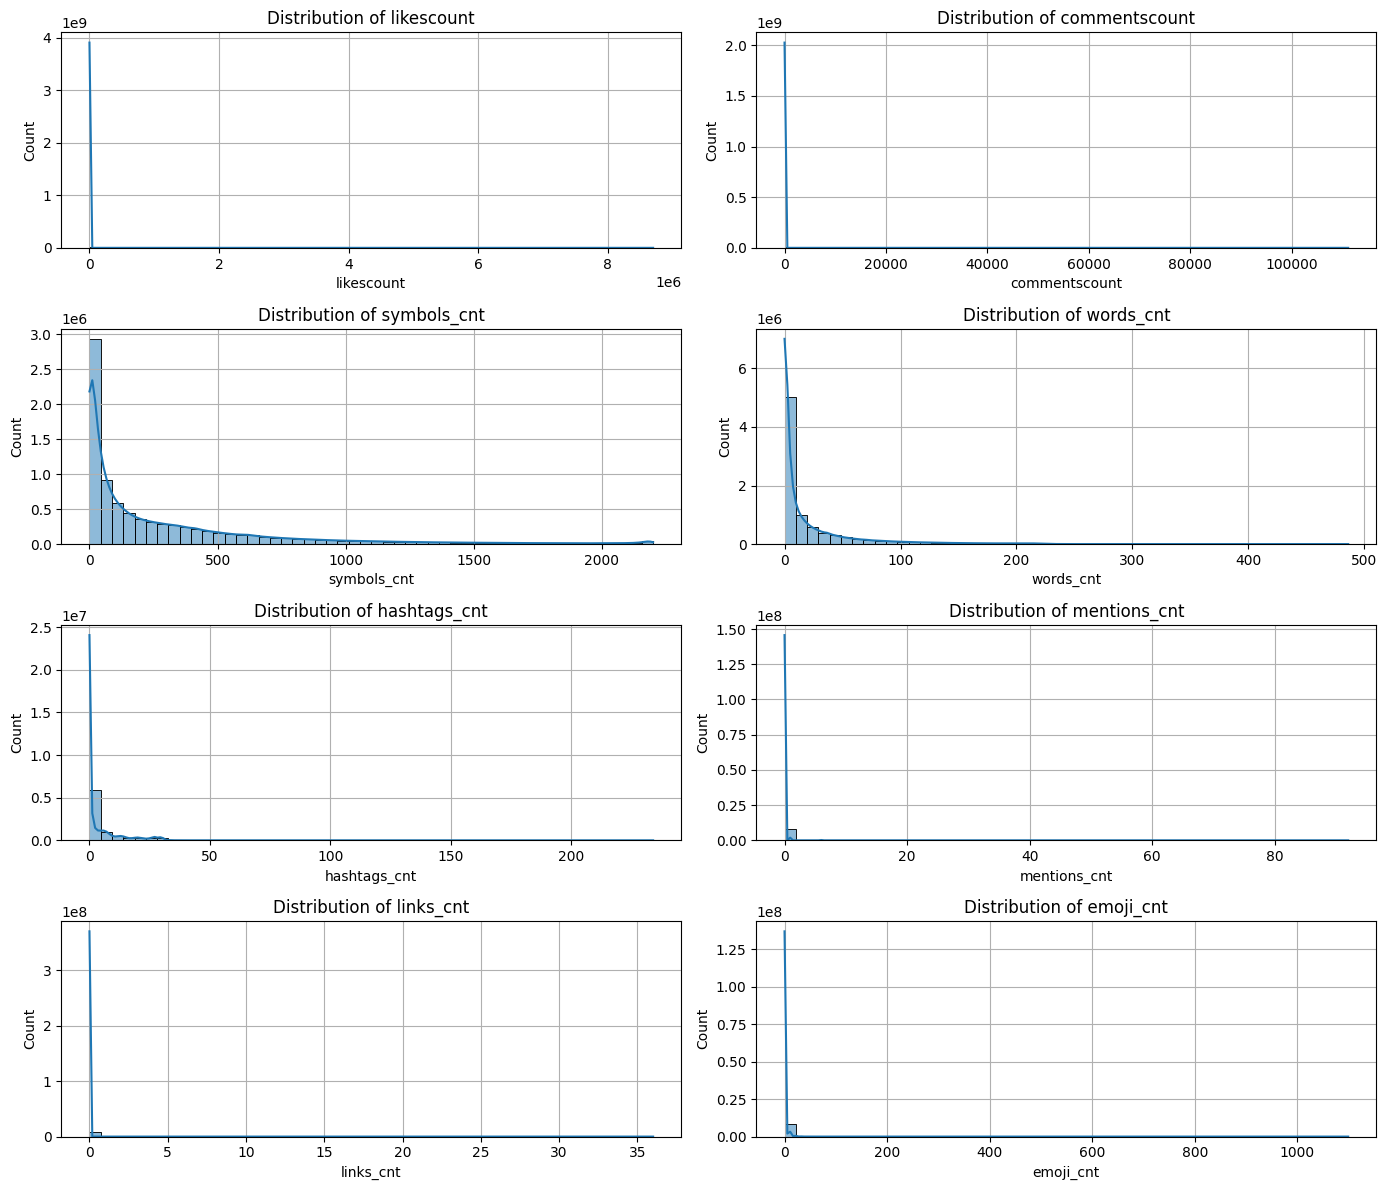

In [15]:
# Plotting distributions for selected columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))

for i, col in enumerate(correlation_cols):
    sns.histplot(train_df[col], ax=axes[i//2, i%2], bins=50, kde=True)
    axes[i//2, i%2].set_title(f'Distribution of {col}')
    axes[i//2, i%2].grid(True)

plt.tight_layout()
plt.show()

**Observation**

*   **Likes and Comments:** The majority of publications receive a small number of likes and comments, with only a few receiving a large number.

*   **Symbols and Words:** Most publications tend to have a small to moderate number of symbols and words. However, there's a peak at zero, indicating some publications might be just images or videos without text.

*   **Hashtags, Mentions, Links, and Emojis**: A significant portion of publications do not use hashtags, mentions, links, or emojis. For the ones that do, the count is typically low



# **Feature Engineering & Aggregation**

*   Temporal features (hour, day, day of the week, month, etc.)
*   Aggregated features (mean likes, comments, etc. for each location)
*   Lag features (number of publications in the previous hours)
*   Rolling statistics (moving averages, etc.)

**Aggregate Data**

*   Aggregate the training data to match the structure of the validation data, i.e., sum of publications by hour and location.


In [16]:
# Generating temporal features
train_df['hour'] = train_df['date'].dt.hour
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek
train_df['month'] = train_df['date'].dt.month


# Aggregating data by hour and location
agg_columns = {
    'likescount': 'mean',
    'commentscount': 'mean',
    'symbols_cnt': 'mean',
    'words_cnt': 'mean',
    'hashtags_cnt': 'mean',
    'mentions_cnt': 'mean',
    'links_cnt': 'mean',
    'emoji_cnt': 'mean'
}

grouped_data = train_df.groupby(['timestamp', 'lon', 'lat', 'hour', 'day', 'dayofweek', 'month']).agg(agg_columns).reset_index()
grouped_data['publication_count'] = train_df.groupby(['timestamp', 'lon', 'lat']).size().values
grouped_data.head()



,timestamp,lon,lat,hour,day,dayofweek,month,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,publication_count
0,1546300800,0.000000,0.000000,0,1,1,1,31.666667,1.666667,51.333333,2.000000,2.000000,0.0,0.0,0.000000,3
1,1546300800,30.136232,60.000054,0,1,1,1,52.000000,1.000000,28.000000,0.500000,2.000000,0.0,0.0,0.500000,2
2,1546300800,30.138478,59.835705,0,1,1,1,32.000000,0.333333,46.000000,2.333333,3.000000,0.0,0.0,1.333333,3
3,1546300800,30.142969,60.023627,0,1,1,1,77.666667,3.333333,34.666667,2.666667,0.666667,0.0,0.0,1.666667,3
4,1546300800,30.142969,60.030359,0,1,1,1,19.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1


In [29]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635541 entries, 0 to 3635540
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          int64  
 1   lon                float64
 2   lat                float64
 3   hour               int32  
 4   day                int32  
 5   dayofweek          int32  
 6   month              int32  
 7   likescount         float64
 8   commentscount      float64
 9   symbols_cnt        float64
 10  words_cnt          float64
 11  hashtags_cnt       float64
 12  mentions_cnt       float64
 13  links_cnt          float64
 14  emoji_cnt          float64
 15  publication_count  int64  
dtypes: float64(10), int32(4), int64(2)
memory usage: 388.3 MB


> The data has been aggregated and the following features have been engineered:

Temporal Features:

1. hour: Hour of the day.
2. day: Day of the month.
3. dayofweek: Day of the week (0 = Monday, 6 = Sunday).
4. month: Month of the year.

Aggregated Features:

5. Mean values for meta-information such as likescount, commentscount, symbols_cnt, and so on.

Target Variable:

6. publication_count: The number of publications in each 250x250 meter polygon for each hour.

# **Model Selection**

Choose a suitable model for time series forecasting. Given the spatial and temporal nature of the data, we might consider:
*   Time series models (ARIMA, Prophet, etc.)
*   Machine learning models (Random Forest, Gradient Boosting, etc.)
*   Deep learning models (LSTM, GRU, etc.), especially if we want to capture long-term patterns




In [17]:
'''
We'll start by splitting the aggregated data into training and validation sets.
Then we'll train each model on the training set and evaluate
its performance on the validation set.
'''

# Drop 'timestamp' as it's strongly correlated with other time features and may cause data leakage
X = grouped_data.drop(['publication_count', 'timestamp'], axis=1)
y = grouped_data['publication_count']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape

((2908432, 14), (727109, 14))

**Observation**

*   Training set: 2908432 samples
*   Validation set: 727109 samples

Each sample has 14 features.

> > We'll fit the ARIMA model to this subset and evaluate its performance.

**Evaluation**

> The objective is for the average relative error across all validation data points (or "cubes") to be less than 2.6.

> Relative Error = {prediction_value} - {ground_truth_value}/{prediction_value}

> The formula calculates the absolute relative difference between the prediction and the ground truth.

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Selecting a specific location for ARIMA demonstration
specific_location = grouped_data.groupby(['lon', 'lat']).size().idxmax()
subset_data = grouped_data[(grouped_data['lon'] == specific_location[0]) & (grouped_data['lat'] == specific_location[1])]

# Splitting the subset data
train_size = int(len(subset_data) * 0.8)
train, test = subset_data['publication_count'][:train_size], subset_data['publication_count'][train_size:]

# ARIMA model parameters
p, d, q = 5, 1, 0
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Forecasting
arima_predictions = model_fit.forecast(steps=len(test))

# Evaluate the ARIMA model
arima_rmse = np.sqrt(mean_squared_error(test, arima_predictions))

# Calculating the relative error for the Gradient Boosting model predictions
arima_relative_errors = np.abs(arima_predictions - y_val) / arima_predictions
arima_average_relative_error = arima_relative_errors.mean()
arima_average_relative_error

/Users/macbookpro/miniconda3/envs/predict_publications_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbookpro/miniconda3/envs/predict_publications_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbookpro/miniconda3/envs/predict_publications_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbookpro/miniconda3/envs/predict_publications_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

0.9515127175695803

> RandomForestRegressor Model

In [19]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_val)

# Evaluate the Random Forest model
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_predictions))

# Calculating the relative error for the Gradient Boosting model predictions
rf_relative_errors = np.abs(rf_predictions - y_val) / rf_predictions
rf_average_relative_error = rf_relative_errors.mean()
rf_average_relative_error

0.3030977957182305

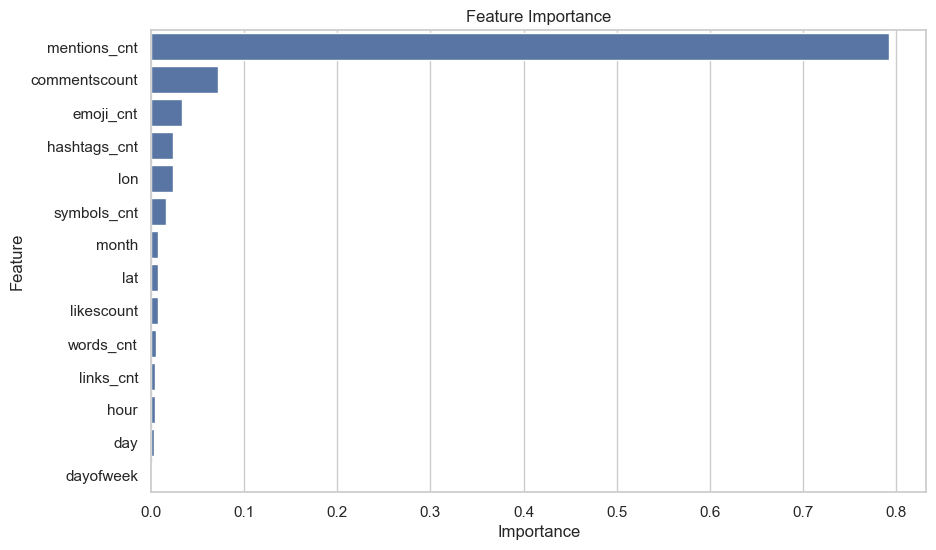

In [20]:
# Feature importance

# Set the visual style of the plot
sns.set(style="whitegrid")

# Get feature importances from your trained model
importances = rf_model.feature_importances_

# Convert importances to a pandas DataFrame
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort DataFrame by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the feature importances
sns.barplot(x='importance', y='feature', data=importances_df)

# Set plot labels and title
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Show the plot
plt.show()


> Gradient Boosting model



In [21]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train the Gradient Boosting model
# gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, random_state=42)

gb_model.fit(X_train, y_train)

# Initialize and train the adjusted Gradient Boosting model

# Predictions
gb_predictions = gb_model.predict(X_val)

# Evaluate the Gradient Boosting model
gb_rmse = np.sqrt(mean_squared_error(y_val, gb_predictions))

# Calculating the relative error for the Gradient Boosting model predictions
gb_relative_errors = np.abs(gb_predictions - y_val) / gb_predictions
gb_average_relative_error = gb_relative_errors.mean()
gb_average_relative_error

0.26012680573629615

> LSTM (Long Short-Term Memory) networks are a type of recurrent neural network (RNN) that can capture long-term dependencies and patterns in time series data. This makes them suitable for our problem.

**To train the LSTM:**

* **Data Scaling:** LSTM networks are sensitive to the scale of input data. We'll scale our features to be in the range [0, 1].

* **Data Reshaping:** LSTM expects the input data to have a specific 3D shape of [samples, time steps, features].

* **Model Building:** We'll define an LSTM architecture.

* **Training:** We'll train the LSTM model.

* **Evaluation:** We'll evaluate its performance on the validation set.

In [23]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshaping data for LSTM [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', )

# Train the model
model.fit(X_train_reshaped, y_train, epochs=3, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=2, shuffle=False)

# Save the Keras model
model.save('lstm_model.keras')

# Prediction
X_new = X_val

# Step 1: Scale and Reshape the New Input Data
X_new_scaled = scaler.transform(X_new)
X_new_reshaped = X_new_scaled.reshape(X_new_scaled.shape[0], 1, X_new_scaled.shape[1])

# Step 2: Use the 'predict' Method to Make Predictions
lstm_predictions = model.predict(X_new_reshaped)

# Be cautious with division by zero in relative error calculation
lstm_relative_errors = np.abs(lstm_predictions.flatten() - y_val) / (lstm_predictions.flatten() + 1e-10)
lstm_average_relative_error = lstm_relative_errors.mean()
print('LSTM Average Relative Error:', lstm_average_relative_error)



Epoch 1/3
90889/90889 - 54s - loss: 16.5508 - val_loss: 16.1899 - 54s/epoch - 589us/step
Epoch 2/3
90889/90889 - 52s - loss: 15.8240 - val_loss: 15.6998 - 52s/epoch - 571us/step
Epoch 3/3
90889/90889 - 50s - loss: 15.5278 - val_loss: 15.5099 - 50s/epoch - 553us/step


/Users/macbookpro/miniconda3/envs/predict_publications_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22723/22723 [==============================] - 6s 268us/step
LSTM Average Relative Error: 0.5618296209176095


**Exponential Smoothening**

> Exponential Smoothing: Uses weighted averages of past observations to forecast.

https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html


In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Selecting a specific location for Exponential Smoothing demonstration
specific_location_es = grouped_data.groupby(['lon', 'lat']).size().idxmax()

# Convert timestamp to datetime format and set it as index
subset_data_es = grouped_data.copy()
subset_data_es['date'] = pd.to_datetime(subset_data_es['timestamp'], unit='s')
subset_data_es = subset_data_es[(subset_data_es['lon'] == specific_location_es[0]) & (subset_data_es['lat'] == specific_location_es[1])].set_index('date')['publication_count']

# Splitting the subset data
train_size_es = int(len(subset_data_es) * 0.8)
train_es = subset_data_es[:train_size_es]
test_es = subset_data_es[train_size_es:]

# Train the Exponential Smoothing model
es_model = ExponentialSmoothing(train_es, trend='add', seasonal='add', seasonal_periods=24)
es_model_fit = es_model.fit()

# Predictions
es_predictions = es_model_fit.forecast(steps=len(test_es))

# Calculating the relative error for the Gradient Boosting model predictions
es_relative_errors = np.abs(es_predictions - y_val) / es_predictions
es_average_relative_error = es_relative_errors.mean()
es_average_relative_error


/Users/macbookpro/miniconda3/envs/predict_publications_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/macbookpro/miniconda3/envs/predict_publications_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/macbookpro/miniconda3/envs/predict_publications_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


0.9374675488378131

# Model Performance

In [25]:
# Create a dictionary with model names as keys and errors as values
error_dict = {
    'Gradient Boosting': gb_average_relative_error,
    'Random Forest': rf_average_relative_error,
    'LSTM': lstm_average_relative_error,
    'ARIMA': arima_average_relative_error,
    'Exponential Smoothing': es_average_relative_error
}

# Convert the dictionary to a Pandas DataFrame
error_df = pd.DataFrame(list(error_dict.items()), columns=['Model', 'Average Relative Error'])
error_df

,Model,Average Relative Error
0,Gradient Boosting,0.260127
1,Random Forest,0.303098
2,LSTM,0.561830
3,ARIMA,0.951513
4,Exponential Smoothing,0.937468


/var/folders/7v/b_qdblv15hg0h789msb73v4r0000gn/T/ipykernel_98233/2832468721.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Relative Error', y='Model', data=error_df, palette='viridis')


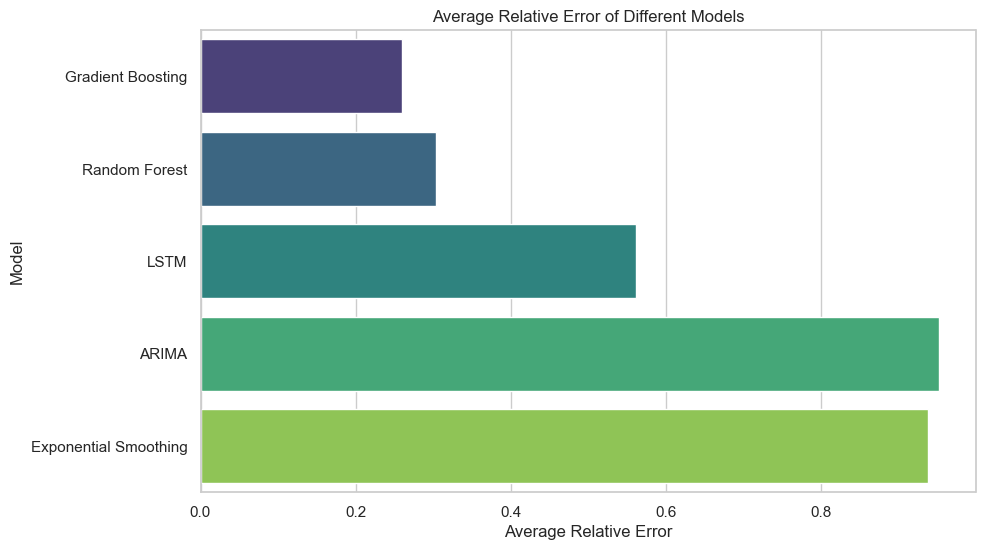

In [26]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the errors
sns.barplot(x='Average Relative Error', y='Model', data=error_df, palette='viridis')

# Set plot labels and title
plt.xlabel('Average Relative Error')
plt.ylabel('Model')
plt.title('Average Relative Error of Different Models')

# Show the plot
plt.show()

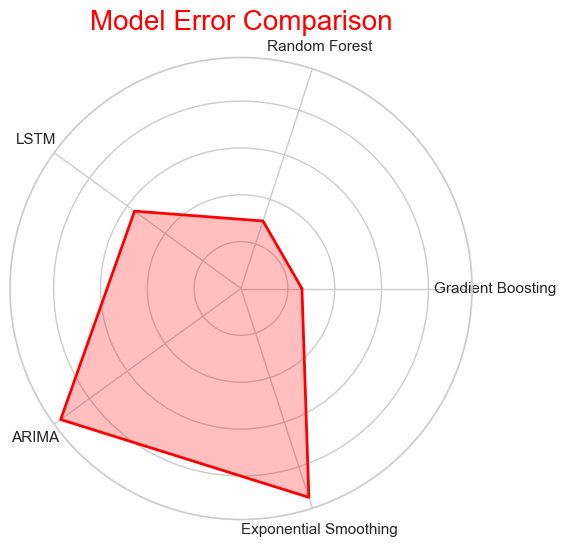

In [27]:
# Number of variables we're plotting.
num_vars = len(error_df['Model'])

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end.
values=error_df['Average Relative Error'].tolist()
values += values[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='red', alpha=0.25)
ax.plot(angles, values, color='red', linewidth=2)

# Labels for each point
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(error_df['Model'])

# Plot the title
ax.set_title('Model Error Comparison', pad=20, color='red', size=20)

plt.show()

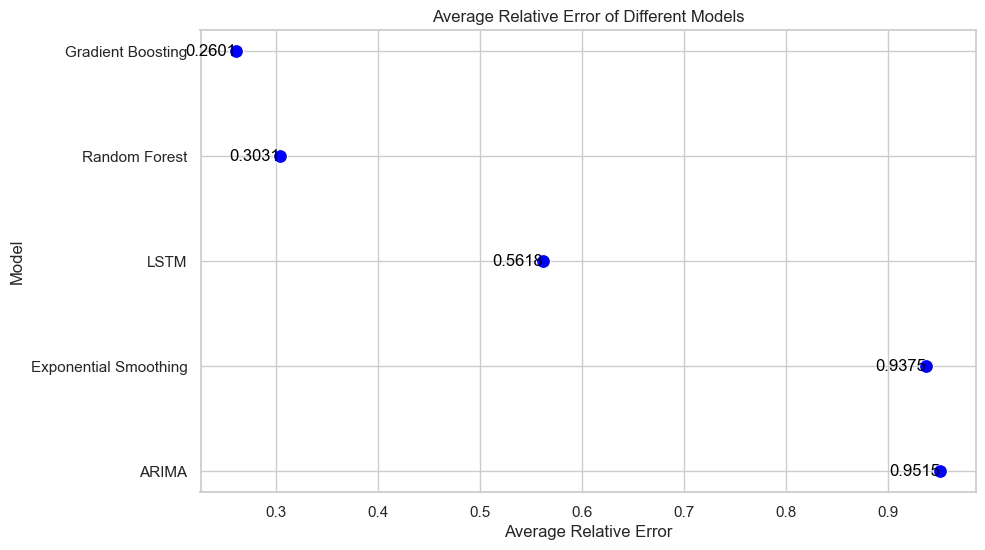

In [28]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Sort the DataFrame by error for better visualization
error_df = error_df.sort_values('Average Relative Error', ascending=True)

# Plot the errors
sns.scatterplot(x='Average Relative Error', y='Model', data=error_df, color='blue', s=100)

# Annotate each point with the corresponding error
for index, row in error_df.iterrows():
    plt.text(row['Average Relative Error'], row['Model'], round(row['Average Relative Error'], 4), color='black', ha="right", va="center")

# Set plot labels and title
plt.xlabel('Average Relative Error')
plt.ylabel('Model')
plt.title('Average Relative Error of Different Models')

# Show the plot
plt.show()